In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow tensorflow_hub librosa scikit-learn matplotlib seaborn joblib

In [3]:
import os
import numpy as np
import librosa
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# Step 1: Load YAMNet model from TensorFlow Hub
print("Loading YAMNet model...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
print("YAMNet loaded.")

Loading YAMNet model...
YAMNet loaded.


In [5]:
# Step 2: Define function to extract YAMNet embeddings from an audio file
def extract_yamnet_embedding(file_path, target_sr=16000):
    """
    Loads an audio file, resamples it to target_sr, and extracts the mean YAMNet embedding.
    """
    waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
    waveform = waveform.astype(np.float32)
    scores, embeddings, spectrogram = yamnet_model(waveform)
    mean_embedding = np.mean(embeddings.numpy(), axis=0)
    return mean_embedding

In [6]:
# Step 3: Prepare dataset paths and labels based on subfolder names
data_dir = '/content/drive/MyDrive/audio_dataset'  # Change to your dataset root path
audio_extensions = ('.wav', '.mp3')

file_paths = []
labels = []

# Traverse the dataset directory structure:
# audio_dataset/
#   deforestation/
#       axe_cutting/
#       chainsaw/
#       ...
#   background/
#       wind/
#       rain/
#       ...
for main_folder in ['deforestation', 'background']:
    main_path = os.path.join(data_dir, main_folder)
    if not os.path.exists(main_path):
        print(f"Warning: {main_path} does not exist, skipping.")
        continue
    for subfolder in os.listdir(main_path):
        subfolder_path = os.path.join(main_path, subfolder)
        if os.path.isdir(subfolder_path):
            for file in os.listdir(subfolder_path):
                if file.lower().endswith(audio_extensions):
                    file_paths.append(os.path.join(subfolder_path, file))
                    labels.append(subfolder)  # Use subfolder name as fine-grained label

print(f"Total audio files found: {len(file_paths)}")
print(f"Unique sub-labels: {len(set(labels))} -> {set(labels)}")

Total audio files found: 1013
Unique sub-labels: 20 -> {'pouring_water', 'axe_chopping', 'rain', 'crow', 'frog', 'insects', 'water_drops', 'crackling_fire', 'chainsaw', 'gunshot', 'footsteps', 'fireworks', 'wind', 'thunderstorm', 'crickets', 'hand_saw', 'chirping_birds', 'door_wood_knock', 'door_wood_creaks', 'snoring'}


In [7]:
# Step 4: Extract embeddings for all audio files (this may take time)
print("Extracting YAMNet embeddings for all audio files...")
embeddings = []
failed_files = []
for fp in file_paths:
    try:
        emb = extract_yamnet_embedding(fp)
        embeddings.append(emb)
    except Exception as e:
        print(f"Failed to process {fp}: {e}")
        failed_files.append(fp)

embeddings = np.array(embeddings)
print(f"Extracted embeddings shape: {embeddings.shape}")

# Remove failed files from labels
if failed_files:
    print(f"Removing {len(failed_files)} failed files from labels.")
    labels = [label for fp, label in zip(file_paths, labels) if fp not in failed_files]

labels = np.array(labels)

Extracting YAMNet embeddings for all audio files...
Extracted embeddings shape: (1013, 1024)


In [8]:
# Step 5: Encode labels to one-hot vectors
label_binarizer = LabelBinarizer()
one_hot_labels = label_binarizer.fit_transform(labels)
class_names = label_binarizer.classes_
print(f"Classes: {class_names}")
print(f"One-hot labels shape: {one_hot_labels.shape}")

Classes: ['axe_chopping' 'chainsaw' 'chirping_birds' 'crackling_fire' 'crickets'
 'crow' 'door_wood_creaks' 'door_wood_knock' 'fireworks' 'footsteps'
 'frog' 'gunshot' 'hand_saw' 'insects' 'pouring_water' 'rain' 'snoring'
 'thunderstorm' 'water_drops' 'wind']
One-hot labels shape: (1013, 20)


In [9]:
# Step 6: Split dataset into train and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, one_hot_labels, test_size=0.2, random_state=42, stratify=one_hot_labels)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 810, Testing samples: 203


In [10]:
# Step 7: Build Keras classifier model with softmax output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

num_classes = len(class_names)

model = Sequential([
    Dense(128, activation='relu', input_shape=(1024,)),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,756 (549.83 KB)

 Trainable params: 140,756 (549.83 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Step 8: Train the model
print("Training the classifier...")
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

Training the classifier...
Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2143 - loss: 2.7679 - val_accuracy: 0.5679 - val_loss: 2.0030
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6164 - loss: 1.8602 - val_accuracy: 0.7346 - val_loss: 1.3274
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7130 - loss: 1.2772 - val_accuracy: 0.8333 - val_loss: 0.8414
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8084 - loss: 0.8223 - val_accuracy: 0.8272 - val_loss: 0.7767
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8350 - loss: 0.6470 - val_accuracy: 0.8519 - val_loss: 0.5927
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8483 - loss: 0.6056 - val_accuracy: 0.8580 - val_loss: 0.5448
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8961 - loss: 0.4676 - val_accuracy: 0.8642 - val_loss: 0.4616
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9238 - loss: 0.3436 - val_

In [12]:
# Step 9: Evaluate the model on the test set
print("\nEvaluating on test set...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred_probs = model.predict(X_test)
y_pred_classes = y_pred_probs.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


Evaluating on test set...
Test Loss: 0.6183
Test Accuracy: 0.8670
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Classification Report:
                  precision    recall  f1-score   support

    axe_chopping       0.91      0.81      0.86        48
        chainsaw       1.00      1.00      1.00         8
  chirping_birds       0.89      1.00      0.94         8
  crackling_fire       0.70      0.88      0.78         8
        crickets       1.00      0.88      0.93         8
            crow       1.00      1.00      1.00         8
door_wood_creaks       0.80      1.00      0.89         8
 door_wood_knock       0.35      0.88      0.50         8
       fireworks       1.00      0.62      0.77         8
       footsteps       1.00      0.62      0.77         8
            frog       0.89      1.00      0.94         8
         gunshot       1.00      1.00      1.00        11
        hand_saw       1.00      0.75      0.86         8
         insects       1.00      0.88      0.93         8


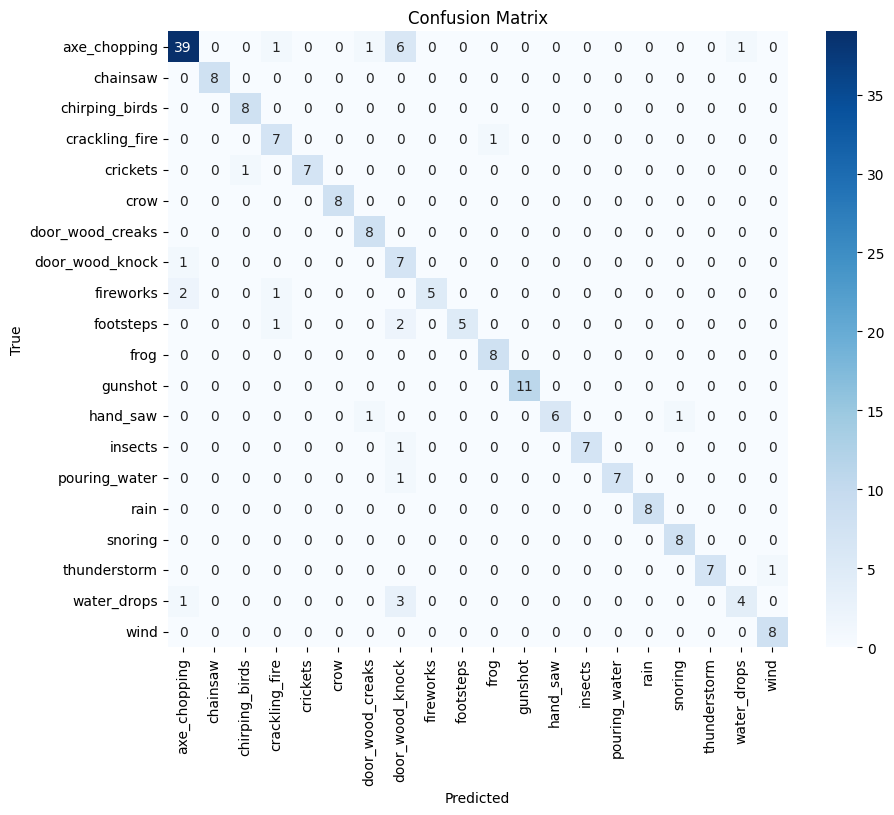

In [13]:
# Plot confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Step 10: Save the trained model and label binarizer
model_save_path = '/content/multi_class_audio_classifier.h5'
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

label_binarizer_path = '/content/label_binarizer.pkl'
joblib.dump(label_binarizer, label_binarizer_path)
print(f"Label binarizer saved to: {label_binarizer_path}")

Model saved to: /content/multi_class_audio_classifier.h5
Label binarizer saved to: /content/label_binarizer.pkl


In [15]:
# Step 11: Function to predict sub-label on new audio file
# def predict_audio_file(file_path, yamnet_model, keras_model, label_binarizer_obj, target_sr=16000):
#     """
#     Predict the sub-label of a given audio file.
#     """
#     waveform, sr = librosa.load(file_path, sr=target_sr, mono=True)
#     waveform = waveform.astype(np.float32)
#     scores, embeddings, spectrogram = yamnet_model(waveform)
#     mean_embedding = np.mean(embeddings.numpy(), axis=0).reshape(1, -1)

#     probs = keras_model.predict(mean_embedding)[0]
#     pred_index = np.argmax(probs)
#     pred_label = label_binarizer_obj.classes_[pred_index]
#     confidence = probs[pred_index]

#     print(f"Predicted sub-label: {pred_label} with confidence {confidence:.3f}")
#     return pred_label, confidence

## batch_predict_folder

In [16]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

def aggregate_probabilities_over_clip(file_path, yamnet_model, keras_model, label_binarizer,
                                      window_size=2.0, hop_size=1.0, sr=16000):
    """
    For a given audio file, compute softmax probabilities per sliding window,
    aggregate over entire clip, and return average probabilities per class.
    """
    waveform, _ = librosa.load(file_path, sr=sr, mono=True)
    waveform = waveform.astype(np.float32)

    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)

    num_windows = max(1, (len(waveform) - window_samples) // hop_samples + 1)

    prob_sums = np.zeros(len(label_binarizer.classes_))

    for i in range(num_windows):
        start_sample = i * hop_samples
        end_sample = start_sample + window_samples
        window_waveform = waveform[start_sample:end_sample]

        if len(window_waveform) < window_samples:
            window_waveform = np.pad(window_waveform, (0, window_samples - len(window_waveform)))

        scores, embeddings, _ = yamnet_model(window_waveform)
        mean_embedding = np.mean(embeddings.numpy(), axis=0).reshape(1, -1)

        probs = keras_model.predict(mean_embedding)[0]
        prob_sums += probs

    avg_probs = prob_sums / num_windows
    percentages = avg_probs * 100
    return percentages

def plot_sound_distribution(percentages, class_names, file_name):
    """
    Plot a bar chart of sound class percentages for a single audio file.
    """
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_labels = class_names[sorted_indices]
    sorted_percentages = percentages[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_labels, sorted_percentages, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage (%)')
    plt.title(f'Sound Class Distribution for {file_name}')
    plt.tight_layout()
    plt.show()

def batch_process_folder(test_folder, yamnet_model, keras_model, label_binarizer):
    """
    Process all audio files in a folder, aggregate probabilities, and plot distributions.
    """
    audio_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')
    for root, _, files in os.walk(test_folder):
        for file in files:
            if file.lower().endswith(audio_extensions):
                file_path = os.path.join(root, file)
                print(f"\nProcessing file: {file}")
                percentages = aggregate_probabilities_over_clip(file_path, yamnet_model, keras_model, label_binarizer)
                for label, pct in zip(label_binarizer.classes_, percentages):
                    print(f"{label}: {pct:.2f}%")
                plot_sound_distribution(percentages, label_binarizer.classes_, file)


Processing file: cuting.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
axe_chopping: 48.78%
chainsaw: 0.03%
chirping_birds: 0.04%
crackling_fire: 19.65%
crickets: 1.42%

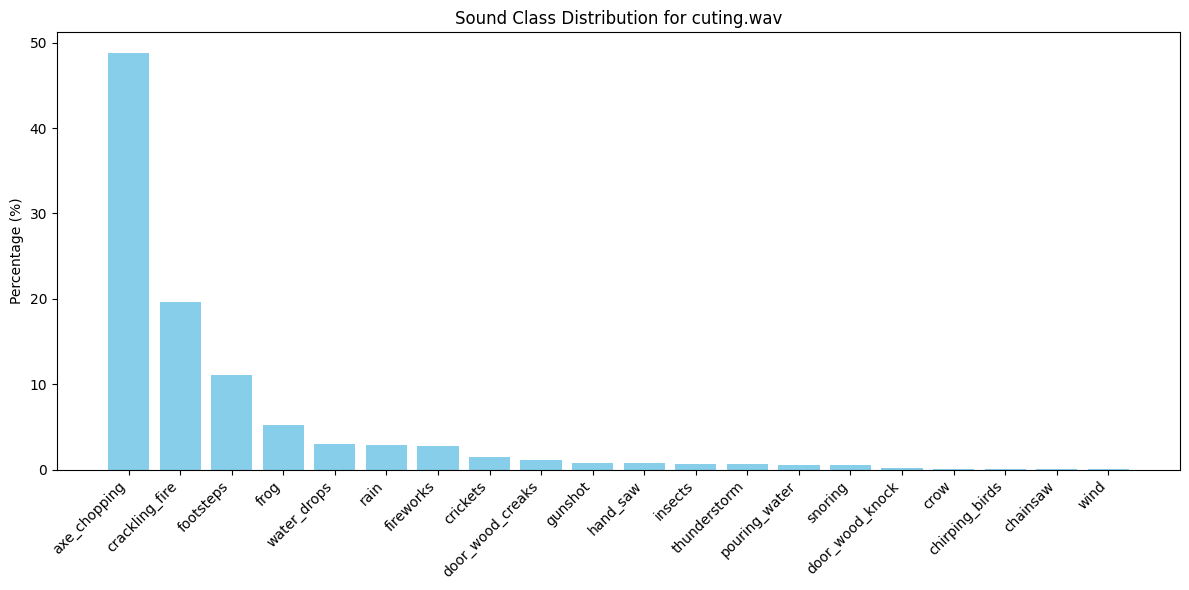


Processing file: normalcutting.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
axe_chopping: 53.65%
chainsaw: 0.01%
chirping_birds: 0.24%
crackling_fire: 6.11%
crickets: 5.14%
crow: 0.53%
door_wood_creaks: 0.06%
door_wood_knock: 0.25%
fireworks: 0.27%
footsteps: 28.49%
frog: 1.93%
gunshot: 0.30%
hand_saw: 0.49%
insects: 0.97%
pouring_water: 0.05%
rain: 0.15

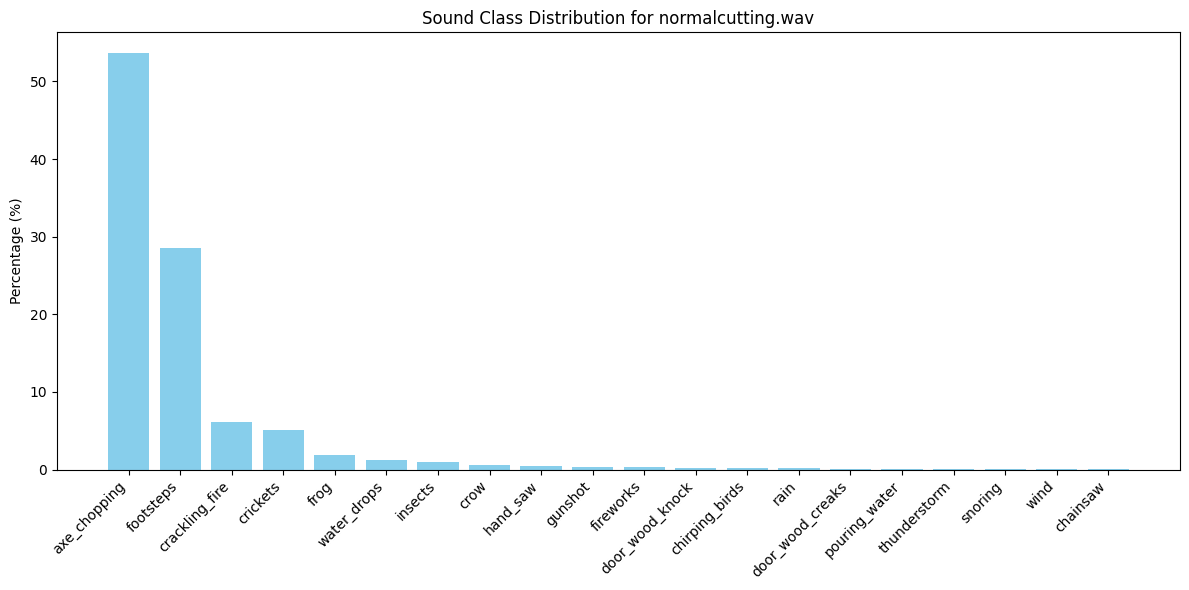


Processing file: test2.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
axe_chopping: 53.65%
chainsaw: 0.01%
chirping_birds: 0.24%
crackling_fire: 6.11%
crickets: 5.14%
crow: 0.53%
door_wood_creaks: 0.06%
door_wood_knock: 0.25%
fireworks: 0.27%
footsteps: 28.49%
frog: 1.93%
gunshot: 0.30%
hand_saw: 0.49%
insects: 0.97%
pouring_water: 0.05%
rain: 0.15%
snorin

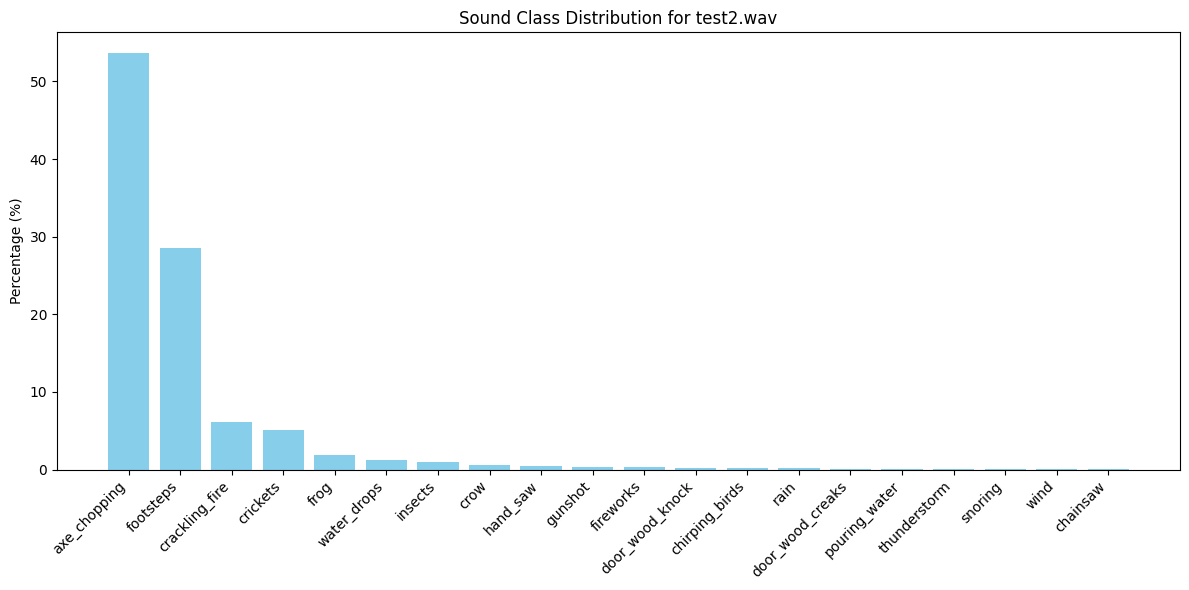


Processing file: mix.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
axe_chopping: 0.00%
chainsaw: 0.00%
chirping_birds: 99.93%
crackling_fire: 0.00%
crickets: 0.00%
crow: 0.06%
door_wood_creaks: 0.00%
door_

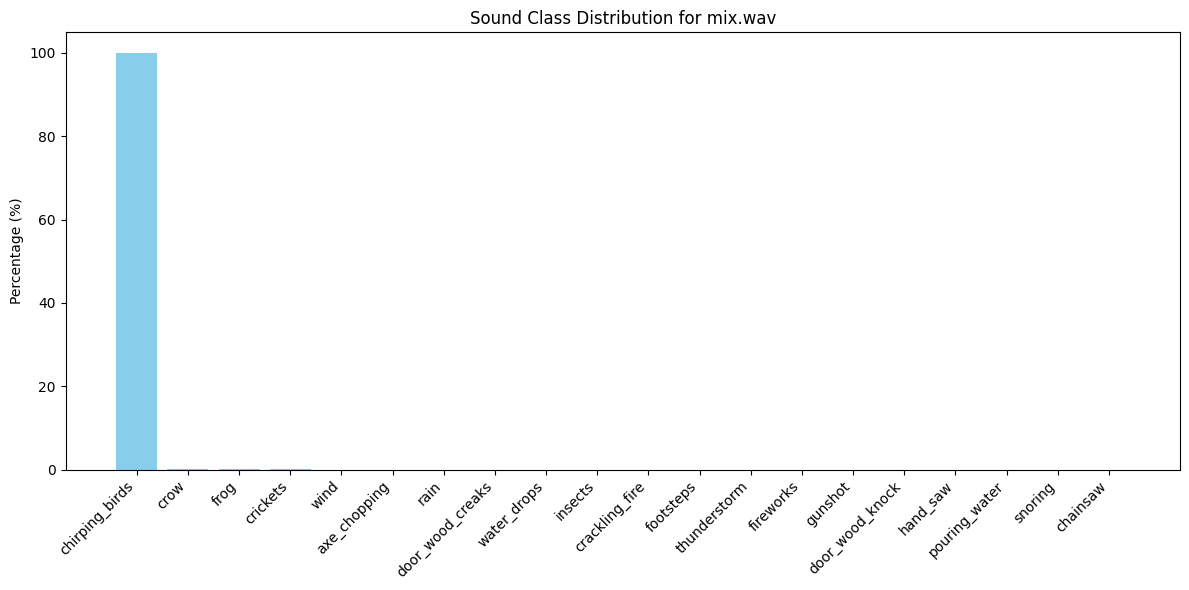


Processing file: gunshot.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━

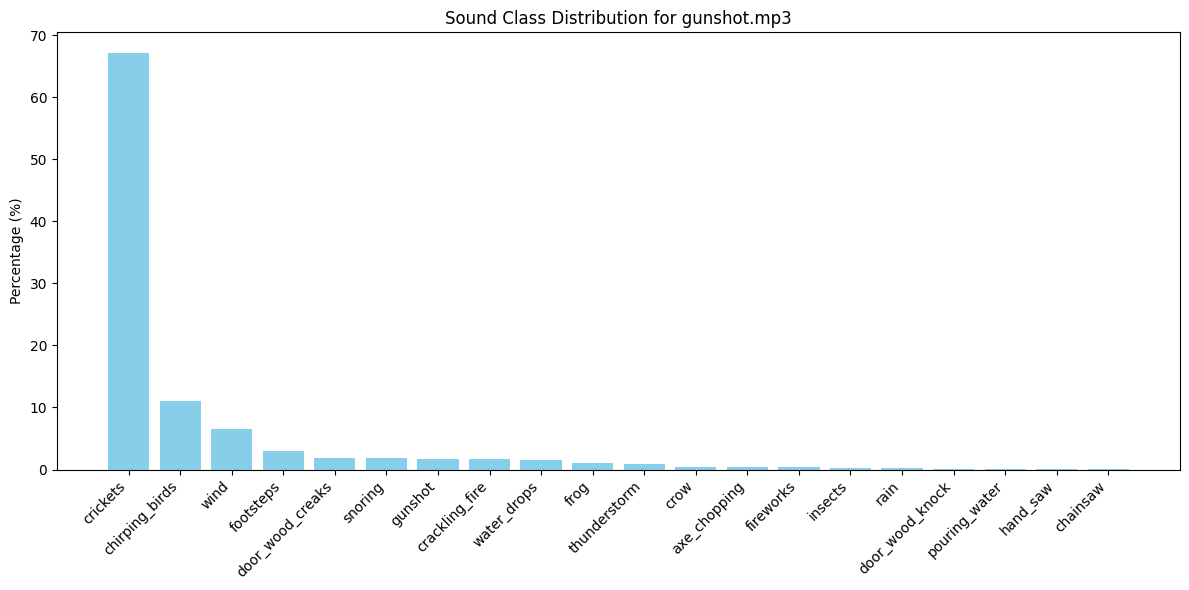


Processing file: nature.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━

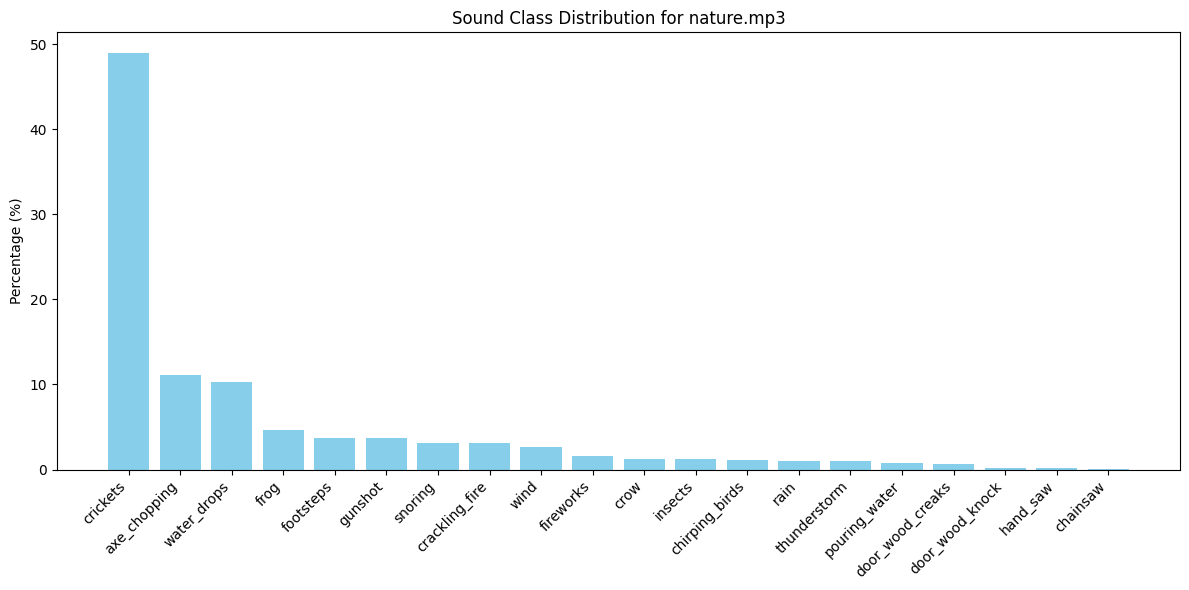


Processing file: zero.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
axe_chopping: 0.20%
chainsaw: 0.08%
chirping_birds: 0.63%
crackling_fire: 0.10%
crickets: 0.08%
crow: 0.33%
door_wood_creaks: 18.39%
door_wood_knock: 0.16%
fireworks: 0.15%
footsteps: 0.43%
frog: 18.42%
gunshot: 0.78%
hand_saw: 0.32%
insects: 20.30%
pouring_water: 0.04%
rain: 0.04%
snoring: 35.42%
thunderstorm: 0.45%
water_drops: 3.63%
wind: 0.05%


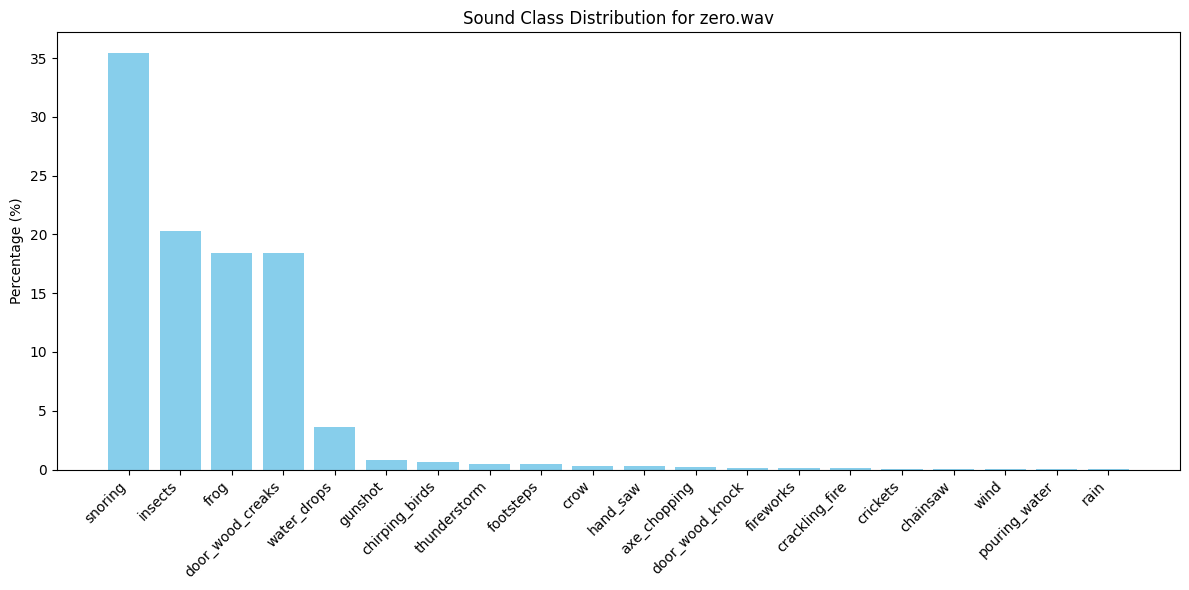

In [17]:
# Usage example:
test_folder_path = '/content/drive/MyDrive/testme'  # Your test folder path
batch_process_folder(test_folder_path, yamnet_model, model, label_binarizer)

## batch_process_folder_with_unknown

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

# def aggregate_probabilities_with_unknown(file_path, yamnet_model, keras_model, label_binarizer,
#                                          window_size=2.0, hop_size=1.0, sr=16000, unknown_threshold=0.4):
#     waveform, _ = librosa.load(file_path, sr=sr, mono=True)
#     waveform = waveform.astype(np.float32)

#     window_samples = int(window_size * sr)
#     hop_samples = int(hop_size * sr)

#     num_windows = max(1, (len(waveform) - window_samples) // hop_samples + 1)

#     prob_sums = np.zeros(len(label_binarizer.classes_))

#     for i in range(num_windows):
#         start_sample = i * hop_samples
#         end_sample = start_sample + window_samples
#         window_waveform = waveform[start_sample:end_sample]

#         if len(window_waveform) < window_samples:
#             window_waveform = np.pad(window_waveform, (0, window_samples - len(window_waveform)))

#         scores, embeddings, _ = yamnet_model(window_waveform)
#         mean_embedding = np.mean(embeddings.numpy(), axis=0).reshape(1, -1)

#         probs = keras_model.predict(mean_embedding)[0]
#         prob_sums += probs

#     avg_probs = prob_sums / num_windows

#     max_prob = np.max(avg_probs)
#     unknown_prob = 0.0
#     if max_prob < unknown_threshold:
#         unknown_prob = 1.0 - np.sum(avg_probs)
#         # Clip unknown_prob to be non-negative (in case sum(avg_probs) > 1 due to numerical issues)
#         unknown_prob = max(0.0, unknown_prob)

#     # Prepare final classes and percentages including unknown
#     final_classes = list(label_binarizer.classes_) + ['unknown']
#     final_percentages = list(avg_probs * 100) + [unknown_prob * 100]

#     return final_classes, final_percentages

# def plot_distribution_with_unknown(classes, percentages, file_name):
#     sorted_indices = np.argsort(percentages)[::-1]
#     sorted_labels = np.array(classes)[sorted_indices]
#     sorted_percentages = np.array(percentages)[sorted_indices]

#     plt.figure(figsize=(12, 6))
#     plt.bar(sorted_labels, sorted_percentages, color='coral')
#     plt.xticks(rotation=45, ha='right')
#     plt.ylabel('Percentage (%)')
#     plt.title(f'Sound Class Distribution with Unknown for {file_name}')
#     plt.tight_layout()
#     plt.show()

# def batch_process_folder_with_unknown(test_folder, yamnet_model, keras_model, label_binarizer,
#                                       unknown_threshold=0.4):
#     audio_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')
#     for root, _, files in os.walk(test_folder):
#         for file in files:
#             if file.lower().endswith(audio_extensions):
#                 file_path = os.path.join(root, file)
#                 print(f"\nProcessing file: {file}")
#                 classes, percentages = aggregate_probabilities_with_unknown(
#                     file_path, yamnet_model, keras_model, label_binarizer,
#                     unknown_threshold=unknown_threshold)
#                 for label, pct in zip(classes, percentages):
#                     print(f"{label}: {pct:.2f}%")
#                 plot_distribution_with_unknown(classes, percentages, file)

# # Usage example:
# test_folder_path = '/content/drive/MyDrive/testme'
# batch_process_folder_with_unknown(test_folder_path, yamnet_model, model, label_binarizer, unknown_threshold=0.4)


## batch_process_folder_with_confidence

In [19]:
# import os
# import librosa
# import numpy as np
# import matplotlib.pyplot as plt

# def aggregate_probabilities_with_confidence_filter(file_path, yamnet_model, keras_model, label_binarizer,
#                                                   window_size=2.0, hop_size=1.0, sr=16000,
#                                                   confidence_threshold=0.6, unknown_threshold=0.4):
#     """
#     Aggregate softmax probabilities over sliding windows in an audio file,
#     only including windows where max class probability >= confidence_threshold.
#     Assign residual probability to 'unknown' class if confidence is low.
#     """
#     waveform, _ = librosa.load(file_path, sr=sr, mono=True)
#     waveform = waveform.astype(np.float32)

#     window_samples = int(window_size * sr)
#     hop_samples = int(hop_size * sr)

#     num_windows = max(1, (len(waveform) - window_samples) // hop_samples + 1)

#     prob_sums = np.zeros(len(label_binarizer.classes_))
#     confident_window_count = 0

#     for i in range(num_windows):
#         start_sample = i * hop_samples
#         end_sample = start_sample + window_samples
#         window_waveform = waveform[start_sample:end_sample]

#         if len(window_waveform) < window_samples:
#             window_waveform = np.pad(window_waveform, (0, window_samples - len(window_waveform)))

#         scores, embeddings, _ = yamnet_model(window_waveform)
#         mean_embedding = np.mean(embeddings.numpy(), axis=0).reshape(1, -1)

#         probs = keras_model.predict(mean_embedding)[0]
#         max_prob = np.max(probs)

#         if max_prob >= confidence_threshold:
#             prob_sums += probs
#             confident_window_count += 1
#         else:
#             # Window considered uncertain; ignored in known class aggregation
#             pass

#     if confident_window_count > 0:
#         avg_probs = prob_sums / confident_window_count
#     else:
#         avg_probs = np.zeros(len(label_binarizer.classes_))

#     unknown_prob = 0.0
#     # If too few confident windows or max avg prob low, assign unknown prob
#     if confident_window_count < num_windows or np.max(avg_probs) < unknown_threshold:
#         unknown_prob = 1.0 - np.sum(avg_probs)
#         unknown_prob = max(0.0, unknown_prob)

#     final_classes = list(label_binarizer.classes_) + ['unknown']
#     final_percentages = list(avg_probs * 100) + [unknown_prob * 100]

#     return final_classes, final_percentages

# def plot_distribution_with_unknown(classes, percentages, file_name):
#     """
#     Plot a bar chart of sound class percentages including unknown class.
#     """
#     sorted_indices = np.argsort(percentages)[::-1]
#     sorted_labels = np.array(classes)[sorted_indices]
#     sorted_percentages = np.array(percentages)[sorted_indices]

#     plt.figure(figsize=(12, 6))
#     plt.bar(sorted_labels, sorted_percentages, color='mediumseagreen')
#     plt.xticks(rotation=45, ha='right')
#     plt.ylabel('Percentage (%)')
#     plt.title(f'Sound Class Distribution with Unknown for {file_name}')
#     plt.tight_layout()
#     plt.show()

# def batch_process_folder_with_confidence(test_folder, yamnet_model, keras_model, label_binarizer,
#                                          confidence_threshold=0.6, unknown_threshold=0.4):
#     """
#     Process all audio files in a folder with confidence filtering and plot distributions.
#     """
#     audio_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')
#     for root, _, files in os.walk(test_folder):
#         for file in files:
#             if file.lower().endswith(audio_extensions):
#                 file_path = os.path.join(root, file)
#                 print(f"\nProcessing file: {file}")
#                 classes, percentages = aggregate_probabilities_with_confidence_filter(
#                     file_path, yamnet_model, keras_model, label_binarizer,
#                     confidence_threshold=confidence_threshold,
#                     unknown_threshold=unknown_threshold)
#                 for label, pct in zip(classes, percentages):
#                     print(f"{label}: {pct:.2f}%")
#                 plot_distribution_with_unknown(classes, percentages, file)

# # Usage example:
# test_folder_path = '/content/drive/MyDrive/testme'  # Update to your test folder path
# batch_process_folder_with_confidence(test_folder_path, yamnet_model, model, label_binarizer,
#                                      confidence_threshold=0.15, unknown_threshold=0.4)



Processing file: cuting.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
axe_chopping: 48.78%
chainsaw: 0.03%
chirping_birds: 0.04%
crackling_fire: 19.65%
crickets: 1.42%

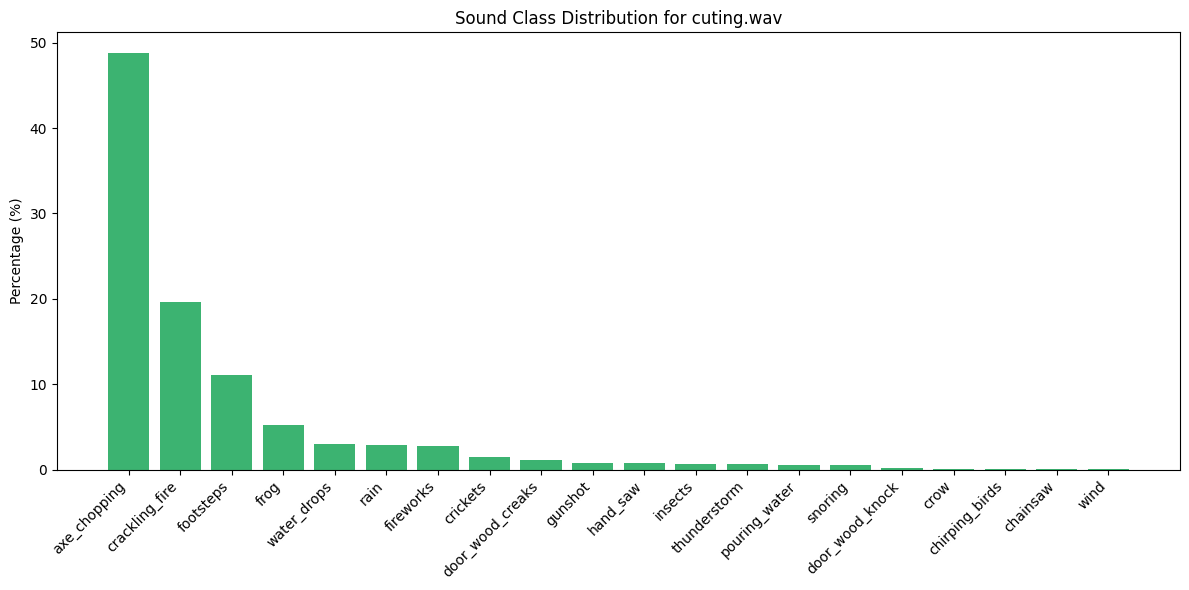


Processing file: normalcutting.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
axe_chopping: 53.65%
chainsaw: 0.01%
chirping_birds: 0.24%
crackling_fire: 6.11%
crickets: 5.14%
crow: 0.53%
door_wood_creaks: 0.06%
door_wood_knock: 0.25%
fireworks: 0.27%
footsteps: 28.49%
frog: 1.93%
gunshot: 0.30%
hand_saw: 0.49%
insects: 0.97%
pouring_water: 0.05%
rain: 0.15

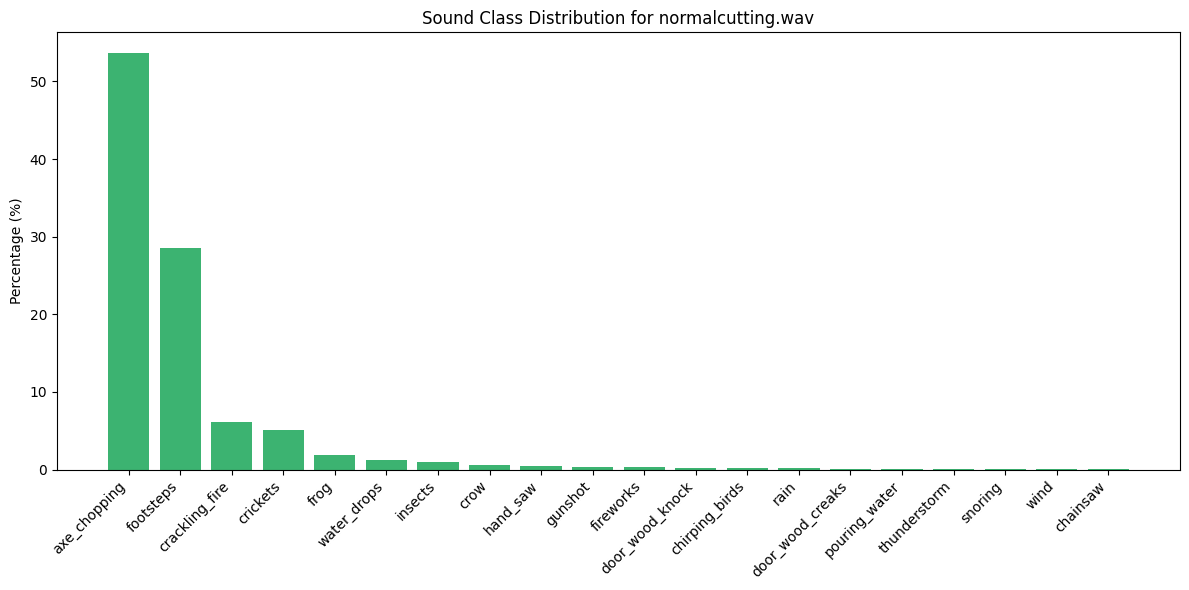


Processing file: test2.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
axe_chopping: 53.65%
chainsaw: 0.01%
chirping_birds: 0.24%
crackling_fire: 6.11%
crickets: 5.14%
crow: 0.53%
door_wood_creaks: 0.06%
door_wood_knock: 0.25%
fireworks: 0.27%
footsteps: 28.49%
frog: 1.93%
gunshot: 0.30%
hand_saw: 0.49%
insects: 0.97%
pouring_water: 0.05%
rain: 0.15%
snorin

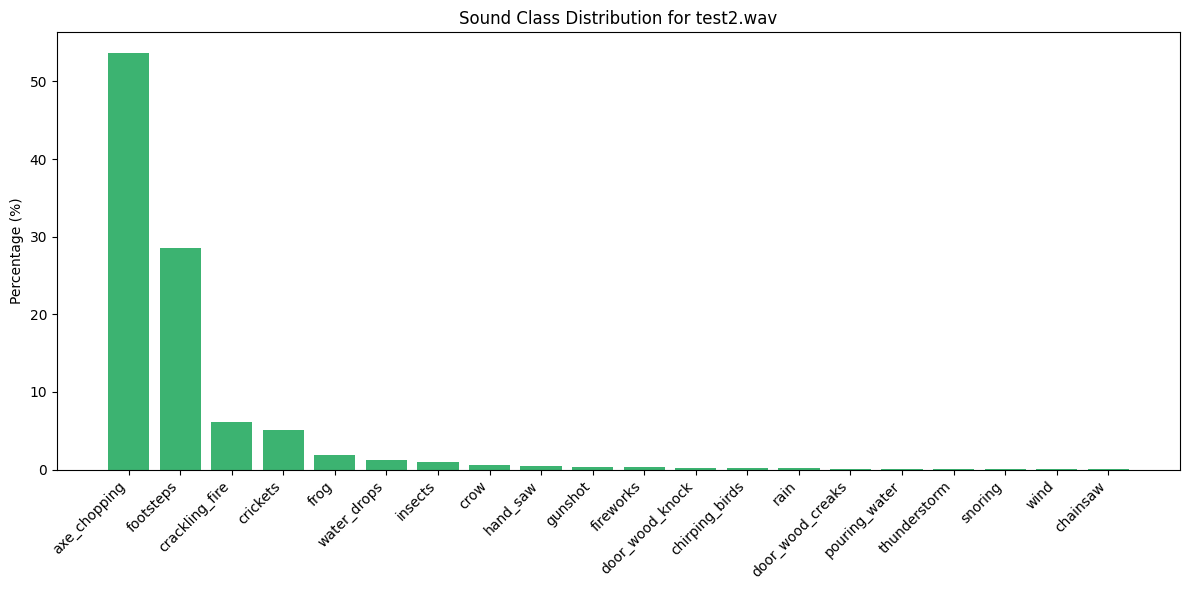


Processing file: mix.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
axe_chopping: 0.00%
chainsaw: 0.00%
chirping_birds: 99.93%
crackling_fire: 0.00%
crickets: 0.00%
crow: 0.06%
door_wood_creaks: 0.00%
door_

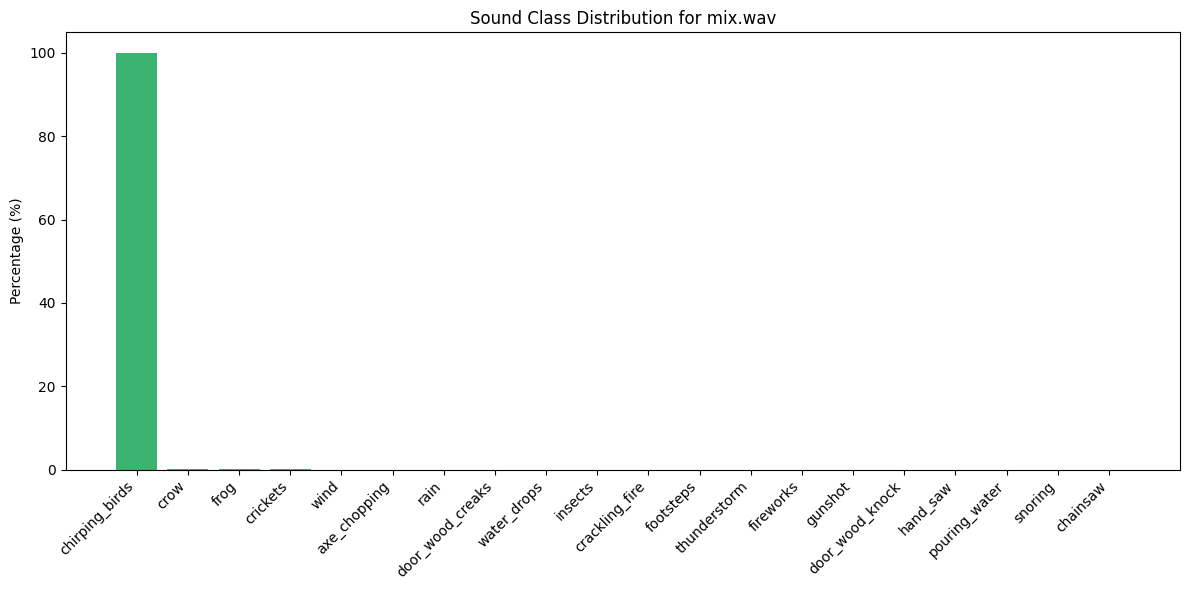


Processing file: gunshot.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━

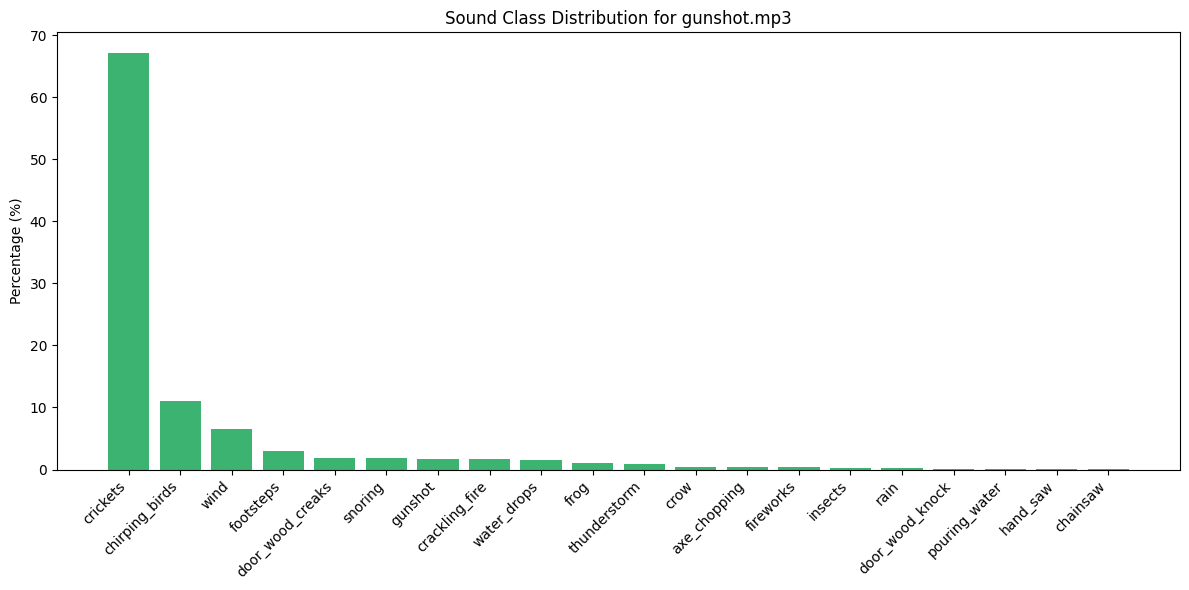


Processing file: nature.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━

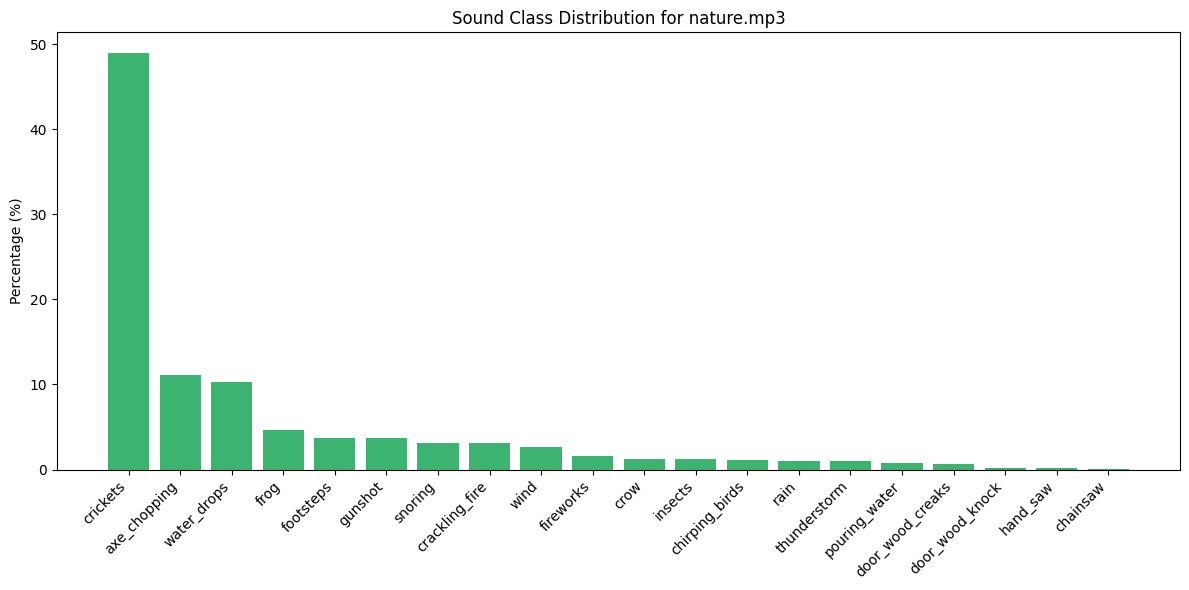


Processing file: zero.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
axe_chopping: 0.20%
chainsaw: 0.08%
chirping_birds: 0.63%
crackling_fire: 0.10%
crickets: 0.08%
crow: 0.33%
door_wood_creaks: 18.39%
door_wood_knock: 0.16%
fireworks: 0.15%
footsteps: 0.43%
frog: 18.42%
gunshot: 0.78%
hand_saw: 0.32%
insects: 20.30%
pouring_water: 0.04%
rain: 0.04%
snoring: 35.42%
thunderstorm: 0.45%
water_drops: 3.63%
wind: 0.05%


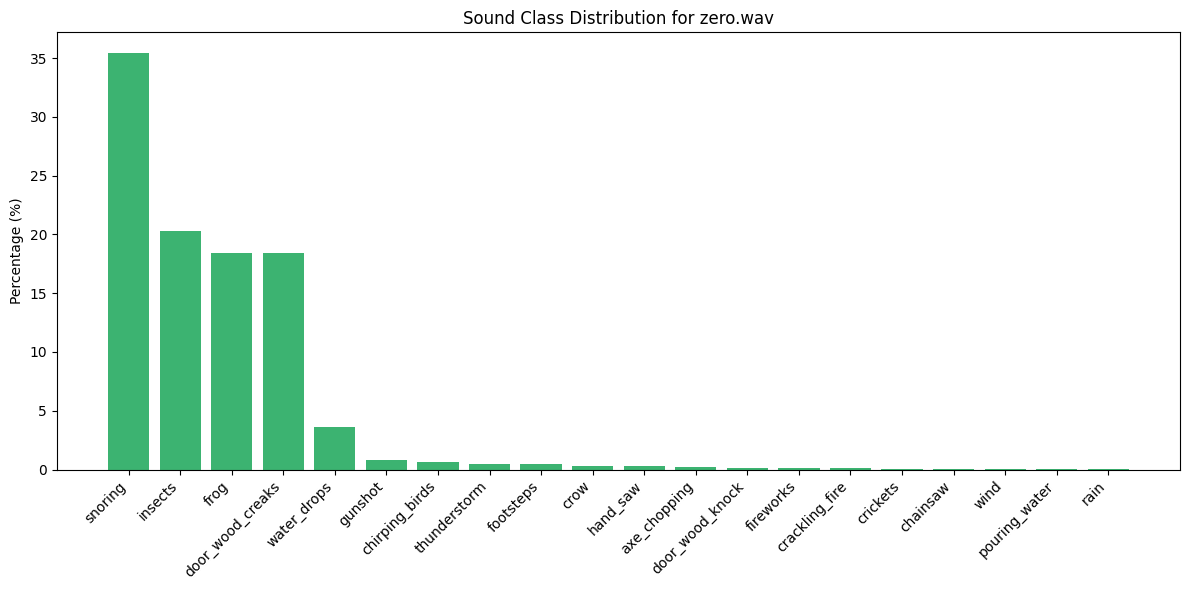

In [20]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

def aggregate_probabilities_with_confidence_filter(file_path, yamnet_model, keras_model, label_binarizer,
                                                  window_size=2.0, hop_size=1.0, sr=16000,
                                                  confidence_threshold=0.6):
    """
    Aggregate softmax probabilities over sliding windows in an audio file,
    only including windows where max class probability >= confidence_threshold.
    Does NOT assign residual probability to 'unknown' class.
    """
    waveform, _ = librosa.load(file_path, sr=sr, mono=True)
    waveform = waveform.astype(np.float32)

    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)

    num_windows = max(1, (len(waveform) - window_samples) // hop_samples + 1)

    prob_sums = np.zeros(len(label_binarizer.classes_))
    confident_window_count = 0

    for i in range(num_windows):
        start_sample = i * hop_samples
        end_sample = start_sample + window_samples
        window_waveform = waveform[start_sample:end_sample]

        if len(window_waveform) < window_samples:
            window_waveform = np.pad(window_waveform, (0, window_samples - len(window_waveform)))

        scores, embeddings, _ = yamnet_model(window_waveform)
        mean_embedding = np.mean(embeddings.numpy(), axis=0).reshape(1, -1)

        probs = keras_model.predict(mean_embedding)[0]
        max_prob = np.max(probs)

        if max_prob >= confidence_threshold:
            prob_sums += probs
            confident_window_count += 1
        else:
            # Window considered uncertain; ignored in known class aggregation
            pass

    if confident_window_count > 0:
        avg_probs = prob_sums / confident_window_count
    else:
        avg_probs = np.zeros(len(label_binarizer.classes_))

    final_classes = list(label_binarizer.classes_)  # No 'unknown' class added
    final_percentages = list(avg_probs * 100)       # No unknown probability added

    return final_classes, final_percentages


def plot_distribution_with_unknown(classes, percentages, file_name):
    """
    Plot a bar chart of sound class percentages.
    """
    sorted_indices = np.argsort(percentages)[::-1]
    sorted_labels = np.array(classes)[sorted_indices]
    sorted_percentages = np.array(percentages)[sorted_indices]

    plt.figure(figsize=(12, 6))
    plt.bar(sorted_labels, sorted_percentages, color='mediumseagreen')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Percentage (%)')
    plt.title(f'Sound Class Distribution for {file_name}')
    plt.tight_layout()
    plt.show()


def batch_process_folder_with_confidence(test_folder, yamnet_model, keras_model, label_binarizer,
                                         confidence_threshold=0.6):
    """
    Process all audio files in a folder with confidence filtering and plot distributions.
    """
    audio_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')
    for root, _, files in os.walk(test_folder):
        for file in files:
            if file.lower().endswith(audio_extensions):
                file_path = os.path.join(root, file)
                print(f"\nProcessing file: {file}")
                classes, percentages = aggregate_probabilities_with_confidence_filter(
                    file_path, yamnet_model, keras_model, label_binarizer,
                    confidence_threshold=confidence_threshold)
                for label, pct in zip(classes, percentages):
                    print(f"{label}: {pct:.2f}%")
                plot_distribution_with_unknown(classes, percentages, file)


# Usage example:
test_folder_path = '/content/drive/MyDrive/testme'  # Update to your test folder path
batch_process_folder_with_confidence(test_folder_path, yamnet_model, model, label_binarizer,
                                     confidence_threshold=0.15)

## Check the plot 5 second


Processing file: cuting.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


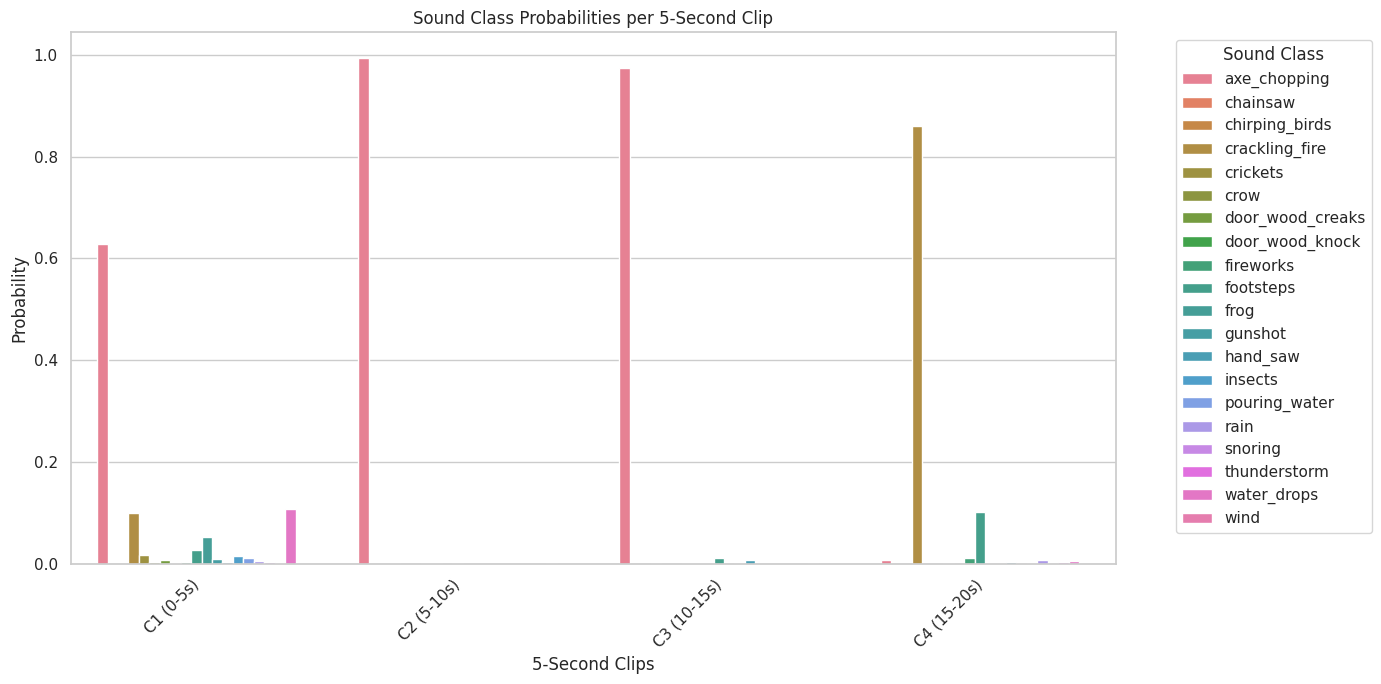


Processing file: normalcutting.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


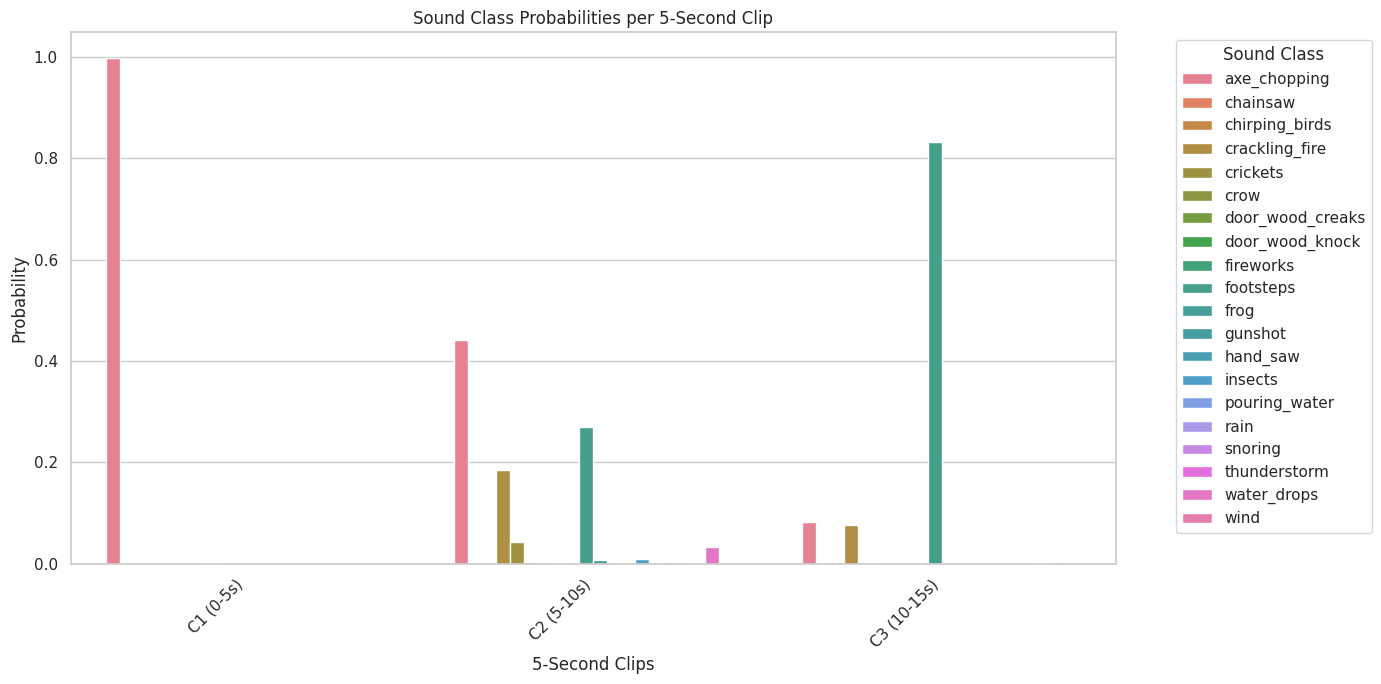


Processing file: test2.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


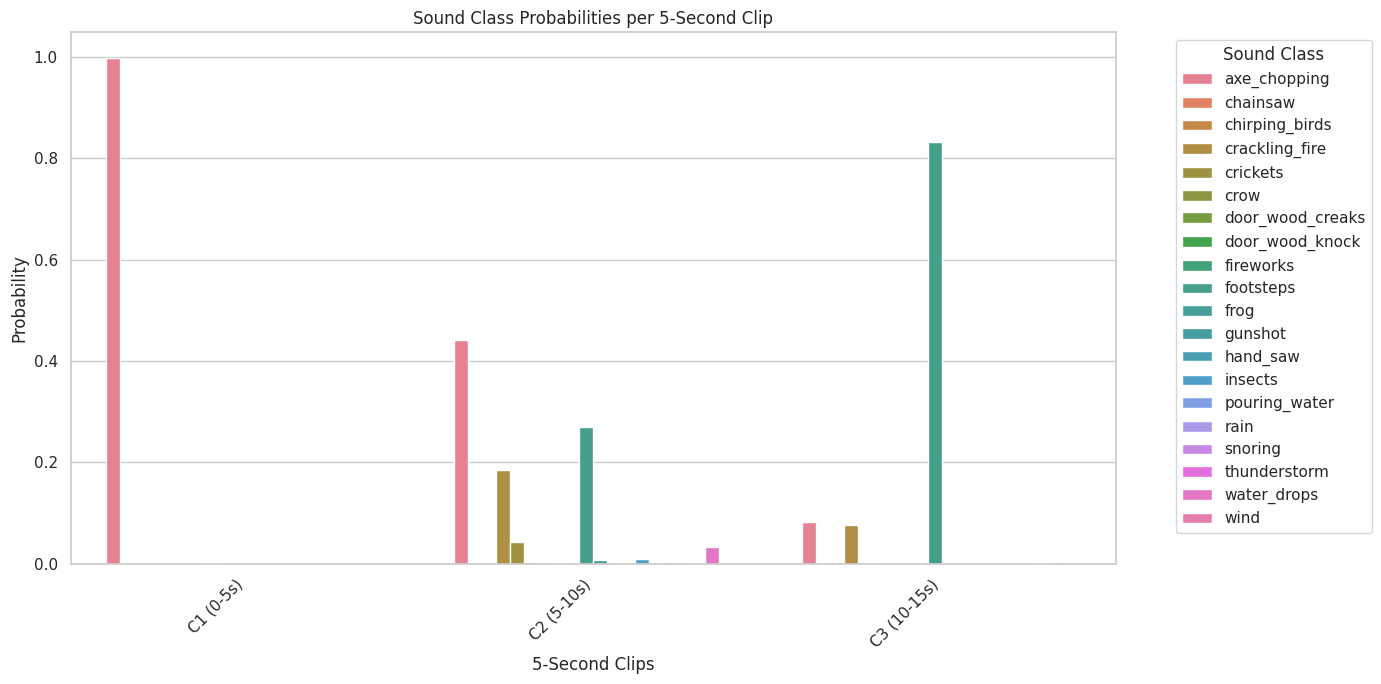


Processing file: mix.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


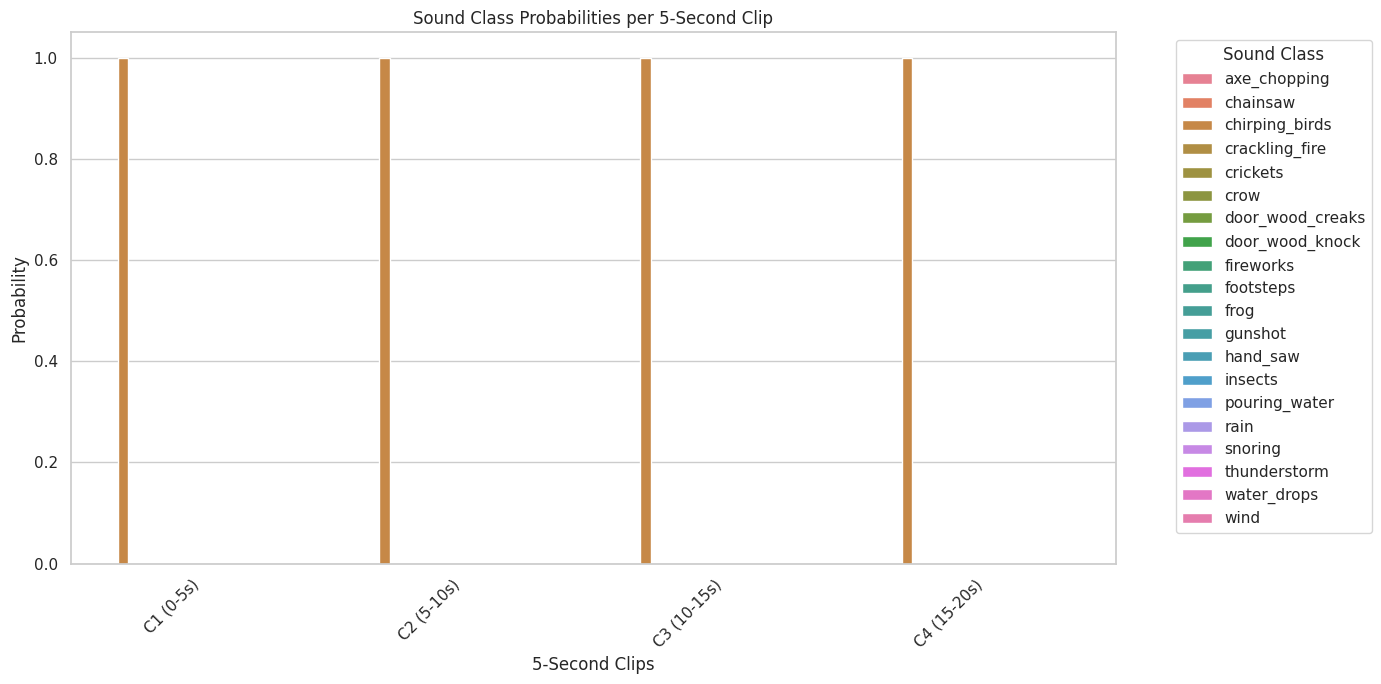


Processing file: gunshot.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━

/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


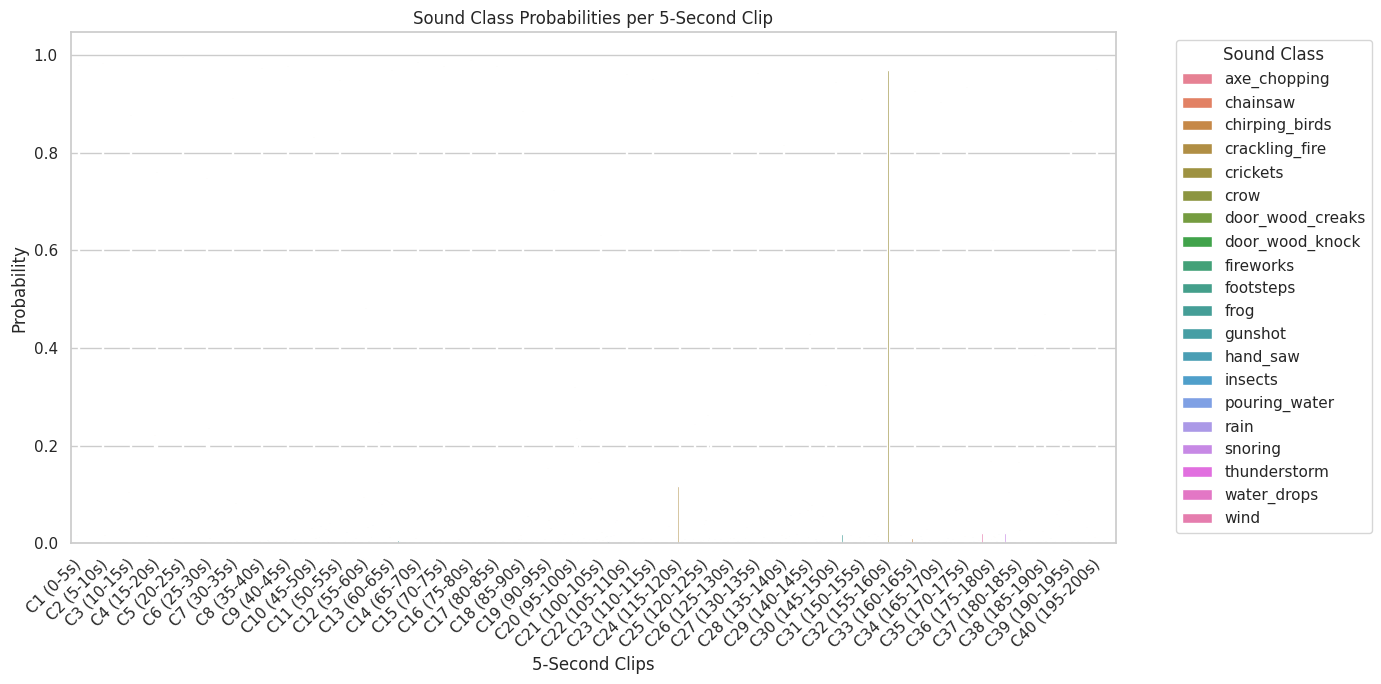


Processing file: nature.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


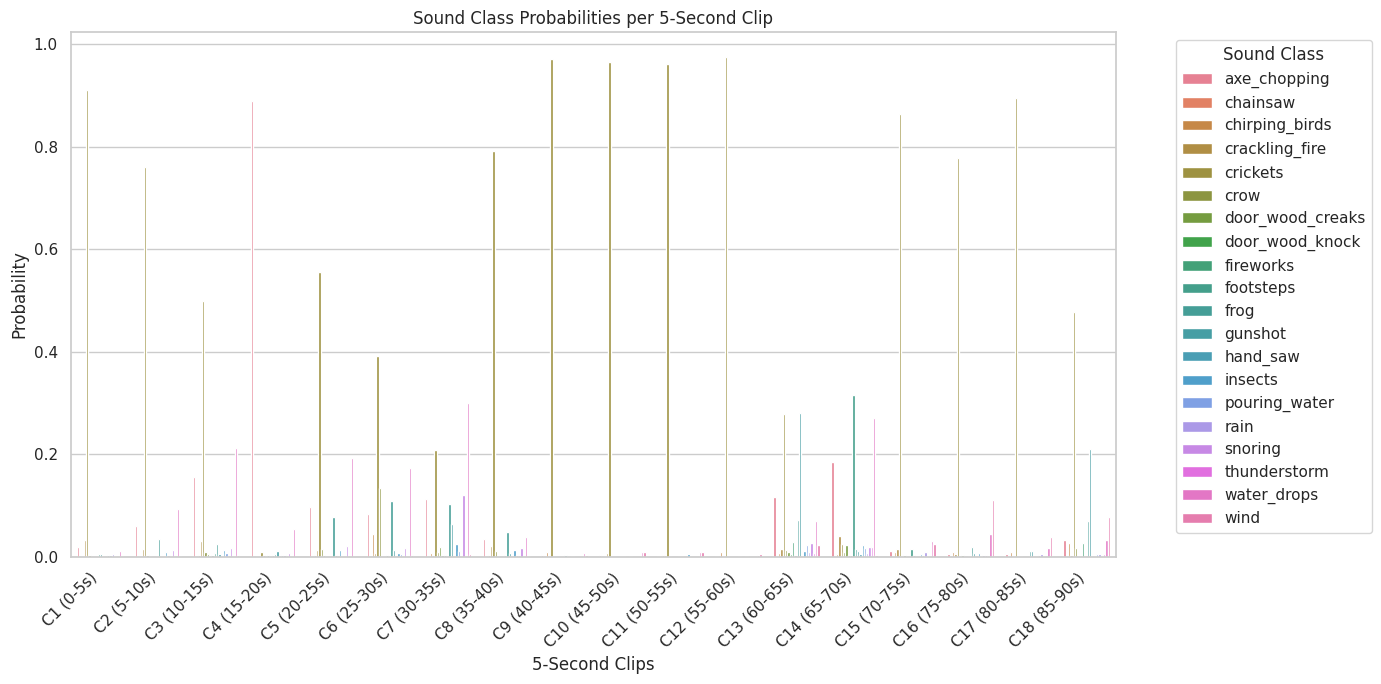


Processing file: zero.wav
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/tmp/ipython-input-21-2820341792.py:61: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)


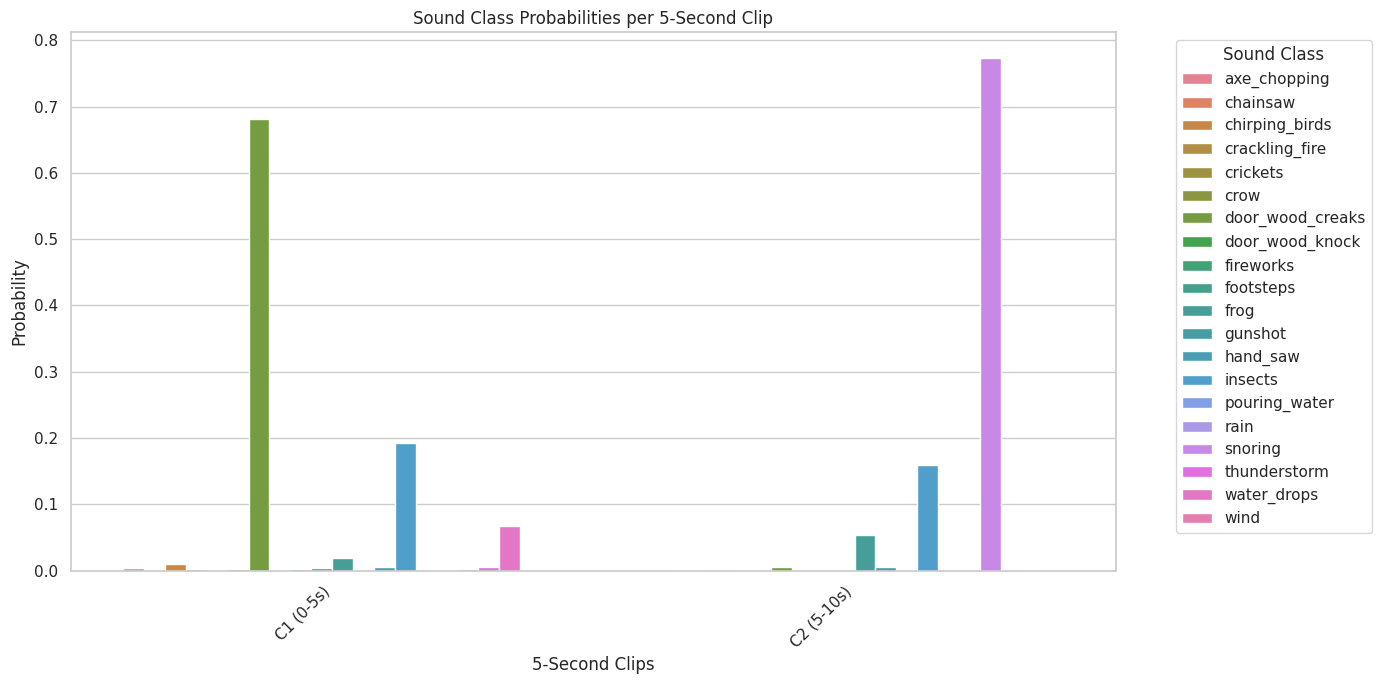

In [21]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def predict_per_5s_clip(file_path, yamnet_model, keras_model, label_binarizer, clip_duration=5.0, sr=16000):
    """
    Splits the audio file into consecutive non-overlapping 5-second clips,
    predicts softmax probabilities for each clip,
    and returns a list of probability arrays (one per clip).
    """
    waveform, _ = librosa.load(file_path, sr=sr, mono=True)
    waveform = waveform.astype(np.float32)

    clip_samples = int(clip_duration * sr)
    total_samples = len(waveform)
    num_clips = total_samples // clip_samples

    clip_probabilities = []

    for i in range(num_clips):
        start = i * clip_samples
        end = start + clip_samples
        clip_waveform = waveform[start:end]

        # Extract YAMNet embeddings
        scores, embeddings, _ = yamnet_model(clip_waveform)
        mean_embedding = np.mean(embeddings.numpy(), axis=0).reshape(1, -1)

        # Predict softmax probabilities
        probs = keras_model.predict(mean_embedding)[0]
        clip_probabilities.append(probs)

    return clip_probabilities

def plot_grouped_bar_seaborn(clip_probabilities, class_names, clip_duration=5.0):
    """
    Creates a grouped bar chart using Seaborn.
    Each group is a 5-second clip (C1, C2, ...),
    each bar is a class probability.
    """
    # Prepare data for seaborn in long format
    data = []
    for clip_idx, probs in enumerate(clip_probabilities):
        clip_label = f'C{clip_idx+1} ({clip_idx*clip_duration:.0f}-{(clip_idx+1)*clip_duration:.0f}s)'
        for class_idx, class_name in enumerate(class_names):
            data.append({
                'Clip': clip_label,
                'Sound Class': class_name,
                'Probability': probs[class_idx]
            })

    df = pd.DataFrame(data)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 7))

    # Create grouped barplot
    ax = sns.barplot(x='Clip', y='Probability', hue='Sound Class', data=df, ci=None)

    ax.set_title('Sound Class Probabilities per 5-Second Clip')
    ax.set_ylabel('Probability')
    ax.set_xlabel('5-Second Clips')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sound Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def batch_process_and_plot_seaborn(test_folder, yamnet_model, keras_model, label_binarizer, clip_duration=5.0, sr=16000):
    """
    Process all audio files in a folder, predict per 5-second clip,
    and plot grouped bar charts per file using Seaborn.
    """
    audio_extensions = ('.wav', '.mp3', '.flac', '.ogg', '.m4a')

    for root, _, files in os.walk(test_folder):
        for file in files:
            if file.lower().endswith(audio_extensions):
                file_path = os.path.join(root, file)
                print(f"\nProcessing file: {file}")
                clip_probs = predict_per_5s_clip(file_path, yamnet_model, keras_model, label_binarizer, clip_duration, sr)
                if clip_probs:
                    plot_grouped_bar_seaborn(clip_probs, label_binarizer.classes_, clip_duration)
                else:
                    print("Audio too short for segmentation.")

# Usage example:
test_folder = '/content/drive/MyDrive/testme'
batch_process_and_plot_seaborn(test_folder, yamnet_model, model, label_binarizer, clip_duration=5.0)


## Single inference

In [22]:
def single_inference_with_confidence(
    file_path, yamnet_model, keras_model, label_binarizer,
    confidence_threshold=0.6
):
    """
    Process a single audio file with confidence filtering and plot the distribution.
    """
    classes, percentages = aggregate_probabilities_with_confidence_filter(
        file_path, yamnet_model, keras_model, label_binarizer,
        confidence_threshold=confidence_threshold
    )
    print(f"\nProcessing file: {os.path.basename(file_path)}")
    for label, pct in zip(classes, percentages):
        print(f"{label}: {pct:.2f}%")
    plot_distribution_with_unknown(classes, percentages, os.path.basename(file_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Processing file: testing.mpeg
axe_chopping: 37.21%
chainsaw: 0.02%
chirping_birds: 0.86%
crackling_fire: 0.09%
crickets: 0.07%
crow: 1.34%
door_wood_creaks: 4.78%
door_wood_knock: 1.51%
fireworks: 1.86%
footsteps: 0.50%
frog: 5.84%
gunshot: 0.30%
hand_saw: 0.94%
insects: 27.28%
pouring_water: 0.21%
rain: 0.26%
snoring: 0.07%
thunderstorm: 0.61%
water_drops: 16.11%
wind: 0.15%


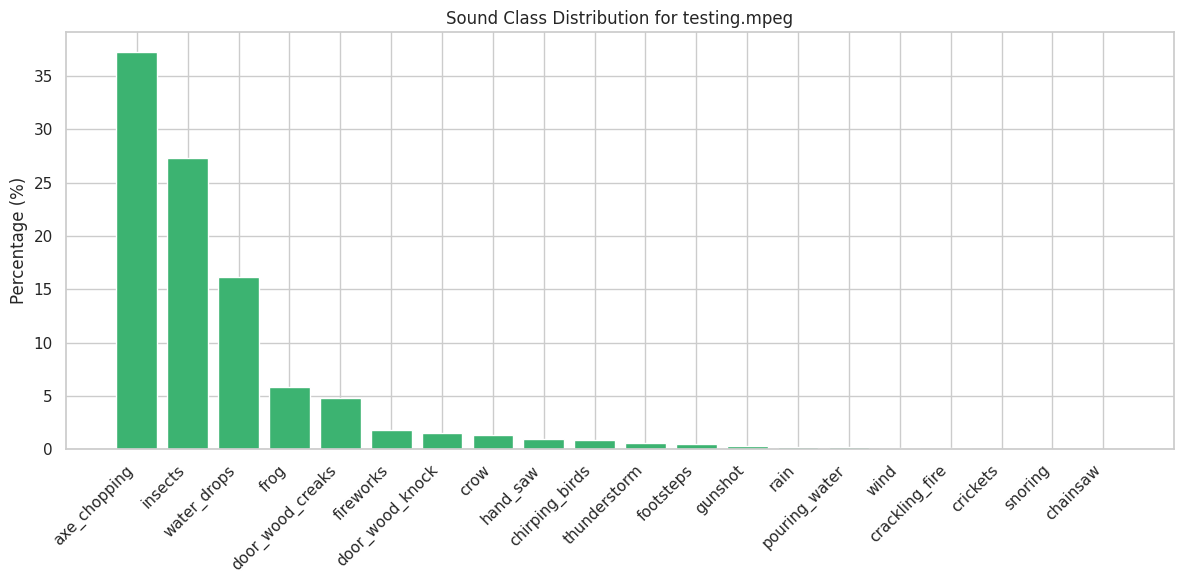

In [23]:
# Usage example:
audio_file_path = '/content/drive/MyDrive/testme/testing.mpeg'  # Update with your file path
single_inference_with_confidence(
    audio_file_path, yamnet_model, model, label_binarizer,
    confidence_threshold=0.15
)